## 0. Configs

In [68]:
# HF_MODEL_NAME = "huawei-noah/TinyBERT_General_4L_312D"
HF_MODEL_NAME = "prajjwal1/bert-small"
MODELS_FOLDER = './models'
MODEL_SAVE_NAME = None
MODEL_LOAD_NAME = None
USE_WANDB = True
USE_CUSTOM_MODEL = True

RS = 42  # Random state
TRAIN_FRACTION = 0.9
BATCH_SIZE = 16
LEARNING_RATE = 3e-5
EPOCHS = 5

## 1. Data loading

### 1.1. Json to Dataframe

In [69]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import json
from tqdm.notebook import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
# Read the raw json
url = 'training_set.json'
with open(url, 'r') as file:
    raw = json.load(file)['data']
data = []
for topic in raw:
    for paragraph in topic['paragraphs']:
        for question in paragraph['qas']:
            assert len(question['answers']) == 1
            answer = question['answers'][0]
            data.append((
                question['id'],
                topic['title'],
                paragraph['context'],
                question['question'],
                answer['text'],
                answer['answer_start'],
                answer['answer_start'] + len(answer['text']),
            ))
dataset = pd.DataFrame(data,
                       columns=('id', 'title', 'context', 'question', 'answer_text', 'answer_start', 'answer_end'))
dataset.head()

,id,title,context,question,answer_text,answer_start,answer_end
0,5733be284776f41900661182,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",To whom did the Virgin Mary allegedly appear i...,Saint Bernadette Soubirous,515,541
1,5733be284776f4190066117f,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is in front of the Notre Dame Main Building?,a copper statue of Christ,188,213
2,5733be284776f41900661180,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",The Basilica of the Sacred heart at Notre Dame...,the Main Building,279,296
3,5733be284776f41900661181,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What is the Grotto at Notre Dame?,a Marian place of prayer and reflection,381,420
4,5733be284776f4190066117e,University_of_Notre_Dame,"Architecturally, the school has a Catholic cha...",What sits on top of the Main Building at Notre...,a golden statue of the Virgin Mary,92,126


In [71]:
dataset: pd.DataFrame = dataset.apply(pd.to_numeric, errors='ignore').convert_dtypes()
# NOTE: stripping makes the test in the next cell fail
# dataset['context'] = dataset['context'].str.strip()
# dataset['question'] = dataset['question'].str.strip()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87599 entries, 0 to 87598
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            87599 non-null  string
 1   title         87599 non-null  string
 2   context       87599 non-null  string
 3   question      87599 non-null  string
 4   answer_text   87599 non-null  string
 5   answer_start  87599 non-null  Int64 
 6   answer_end    87599 non-null  Int64 
dtypes: Int64(2), string(5)
memory usage: 4.8 MB


In [72]:
# Simple tests
for _, q in dataset.iterrows():
    assert q['answer_text'] == q['context'][q['answer_start']:q['answer_end']]
print("TEST PASSED: answer-text == context[start:end]")

TEST PASSED: answer-text == context[start:end]


### 1.2. Data exploration

99% percentile of context word count: 282


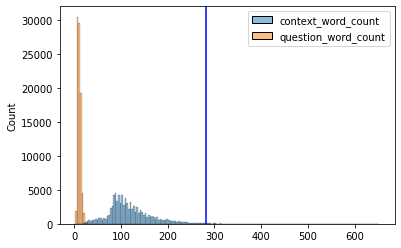

In [73]:
import seaborn as sns

sentence_lengths = pd.DataFrame(
    dataset[['context', 'question']].applymap(str.split).applymap(len).to_numpy(),
    columns=['context_word_count', 'question_word_count'],
)
quantile99 = int(np.quantile(sentence_lengths['context_word_count'], 0.99))

ax = sns.histplot(sentence_lengths)
ax.axvline(x=quantile99, color='b')
print(f"99% percentile of context word count: {quantile99}")
# Note: after tokenization the numbers may differ but not dramatically

### 1.3. Tokenization

In [74]:
import torch
from transformers import AutoTokenizer, PreTrainedTokenizerFast

tokenizer: PreTrainedTokenizerFast = AutoTokenizer.from_pretrained(HF_MODEL_NAME)

In [75]:
s = "Test sequence"
t = tokenizer("Test sequence")
print(s)
print(tokenizer.decode(t['input_ids']))

Test sequence
[CLS] test sequence [SEP]


In [ ]:
# Tokenize the context and questions
tok = []
log_answers_not_found = 0

for _, row in tqdm(dataset.iterrows(), total=dataset.shape[0]):
    # Standard tokenizer
    t = tokenizer(
        row['question'],
        row['context'],
        max_length=512,
        truncation='only_second',
        padding='max_length',
        return_offsets_mapping=True,
    )

    offset_mapping = np.array(t['offset_mapping'])
    token_type_ids = np.array(t['token_type_ids'])

    # Get where the answer is located, by looking at tokens that satisfy:
    #  - they start after the answer
    #  - they end before the answer
    #  - they are part of the context
    answer_context = (
            (offset_mapping[:, 0] >= row['answer_start']) *
            (offset_mapping[:, 1] <= row['answer_end']) *
            token_type_ids.astype(bool)
    )

    # Note: for now truncation is not handled
    # Debug printing
    # print(row['answer_text'])
    # print(tokenizer.decode(np.array(t['input_ids'])[answer_context]))
    # print(answer_context)

    # Get the first and last index of the answer context
    answer_tok_idx = np.argwhere(answer_context).ravel()
    isp = iep = 0
    if answer_tok_idx.size == 0:
        log_answers_not_found += 1
    else:
        isp = answer_tok_idx[0]
        iep = answer_tok_idx[-1]
        assert isp <= iep

    tok.append({
        'input_ids': torch.tensor(t['input_ids']),
        'token_type_ids': torch.tensor(token_type_ids),
        'attention_mask': torch.tensor(t['attention_mask']),
        'start_positions': torch.tensor(isp),
        'end_positions': torch.tensor(iep),
        'offset_mapping': offset_mapping,
    })

print(f"Answers not found: {log_answers_not_found}")
# To handle this, we need to do handle larger inputs by slicing or ignore it

  0%|          | 0/87599 [00:00<?, ?it/s]

In [ ]:
tokenized_dataset = pd.concat((dataset, pd.DataFrame(tok)), axis=1)
tokenized_dataset.head()

In [ ]:
# Test how the questions+context are tokenized and decoded
q = tokenized_dataset.iloc[0]
s = q['question'] + q['context']
t = q['input_ids']
print(s)
print()
print(tokenizer.decode(t))

### 1.4. Train-Val split

In [ ]:
# Get the questions' titles and shuffle them
titles = tokenized_dataset['title'].unique()
shuffled_titles = pd.Series(titles).sample(frac=1, random_state=RS)

# Get the Question Indices grouped by title
qi_by_titles = tokenized_dataset.groupby(['title']).indices
training_indices = []
min_train_len = int(len(tokenized_dataset) * TRAIN_FRACTION)

# Add questions until enough are present
for title in shuffled_titles:
    training_indices += qi_by_titles[title].tolist()
    if len(training_indices) >= min_train_len:
        break

# Create the datasets using the indices
ds_train = tokenized_dataset.iloc[training_indices]
ds_val = tokenized_dataset.drop(ds_train.index)

print(f"Training samples: {len(ds_train)}")
print(f"Validation samples: {len(ds_val)}")
print(f"Actual fraction: {len(ds_train) / len(tokenized_dataset):.4f}")

### 1.5. Converting the data for PyTorch

In [ ]:
from torch.utils.data import DataLoader, Dataset


class QADataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        return {
            'input_ids': item['input_ids'],
            'token_type_ids': item['token_type_ids'],
            'attention_mask': item['attention_mask'],
            'start_positions': item['start_positions'],
            'end_positions': item['end_positions']
        }

In [ ]:
train_loader = DataLoader(QADataset(ds_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(QADataset(ds_val), batch_size=BATCH_SIZE, shuffle=False)

## 2. Training the model

### 2.1. Loading the model
[docs](https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForQuestionAnswering)

### 2.1.1. Custom model definition

In [ ]:
from transformers.modeling_outputs import QuestionAnsweringModelOutput
from transformers import BertModel
from transformers import BertForQuestionAnswering
from torchinfo import torchinfo
import torch.nn as nn


class BertForQuestionAnsweringCustom(nn.Module):
    """
    Bert Model for Question Answering Tasks.
    """

    def __init__(self, bert_model, num_labels=512, finetune_bert=True):
        """
        @param    bert_model: A BertModel object
        @param    num_labels: Number of labels
        @param    finetune_bert (bool): Whether to fine-tune the BERT model or not
        """
        super(BertForQuestionAnsweringCustom, self).__init__()

        self.bert_model = bert_model
        self.num_labels = num_labels
        self.qa_head = self.create_head()
        self.finetune_bert(finetune_bert)

    @classmethod
    def from_pretrained(cls, bert_name, num_labels=512, finetune_bert=True):
        bert_model = BertModel.from_pretrained(bert_name)
        return cls(bert_model, num_labels=num_labels, finetune_bert=finetune_bert)

    def finetune_bert(self, finetune):
        for param in self.bert_model.parameters():
            param.requires_grad = finetune

    def create_head(self):
        return nn.Linear(self.bert_model.config.hidden_size, self.num_labels * 2)

    @classmethod
    def loss_fn(cls, start_pred, start_true, end_pred, end_true):
        individual_loss_fn = nn.CrossEntropyLoss()
        start_loss = individual_loss_fn(start_pred, start_true)
        end_loss = individual_loss_fn(end_pred, end_true)
        loss = (start_loss + end_loss) / 2

        return loss

    def forward(self,
                input_ids=None,
                attention_mask=None,
                token_type_ids=None,
                position_ids=None,
                head_mask=None,
                inputs_embeds=None,
                start_positions=None,
                end_positions=None,
                output_attentions=None,
                output_hidden_states=None,
                return_dict=None
                ):
        """
        Feed input to BERT and the classifier to compute logits.
        """
        # Feed input to BERT
        outputs = self.bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict
        )

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to the head to compute logits
        logits = self.qa_head(last_hidden_state_cls)
        split = logits.split(self.num_labels, dim=1)
        start_logits = split[0]
        end_logits = split[1]

        total_loss = None
        if start_positions is not None and end_positions is not None:
            total_loss = self.loss_fn(start_logits, start_positions, end_logits, end_positions)

        return QuestionAnsweringModelOutput(
            loss=total_loss,
            start_logits=start_logits,
            end_logits=end_logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
if USE_CUSTOM_MODEL:
    model: BertForQuestionAnsweringCustom = BertForQuestionAnsweringCustom.from_pretrained(HF_MODEL_NAME)
    print("Using custom model")
else:
    model: BertForQuestionAnswering = BertForQuestionAnswering.from_pretrained(HF_MODEL_NAME)
    print("Using Huggingface Question Answering model")

In [ ]:
torchinfo.summary(model)

### 2.2. Metrics

In [ ]:
import evaluate


def calc_f1(answer_text, answer_text_pred):
    f1s = []
    for text, pred in zip(answer_text, answer_text_pred):
        f1s.append(evaluate.compute_f1(text, pred))
    return pd.Series(f1s, name='f1')
    # return evaluate.compute_f1(answer_text, answer_text_pred)


def calc_em_str(answer_text, answer_text_pred):
    # Use string comparison
    return (answer_text == answer_text_pred).astype(int).rename('em')


def calc_em_tensor(answer_start, answer_end, answer_start_pred, answer_end_pred):
    # Use TOKEN index comparison
    return torch.logical_and(
        answer_start == answer_start_pred,
        answer_end == answer_end_pred,
    ).float()

### 2.3. Validation / Evaluation function

In [ ]:
def evaluate_model(model, loader: DataLoader, return_frame=False, display_bar=False):
    _loader = tqdm(loader) if display_bar else loader

    # Store the answers' TOK indices
    answer_start_tok= []
    answer_end_tok=[]


    # Get outputs from the model
    model.to(device)
    model.eval()
    with torch.no_grad():
        for batch in _loader:
            args = dict(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                token_type_ids=batch['token_type_ids'].to(device),
            )
            outputs = model(**args)

            # Get the answers' TOK indices
            answer_start_tok += torch.argmax(outputs['start_logits'], dim=1).tolist()
            answer_end_tok += torch.argmax(outputs['end_logits'], dim=1).tolist()

    # Convert the TOK indices into TEXT using the context
    df = loader.dataset.df.reset_index()
    answer_text_pred = []
    for idx, row in df.iterrows():
        om = row['offset_mapping']
        tst, ten = answer_start_tok[idx], answer_end_tok[idx]  # Tok start, tok end
        cst, cen = om[tst, 0], om[ten, 1]  # Char start, Char end
        answer_text_pred.append(row['context'][cst:cen])
    answer_text_pred = pd.Series(answer_text_pred)

    # Compute the metrics
    f1s = calc_f1(df['answer_text'], answer_text_pred)
    ems = calc_em_str(df['answer_text'], answer_text_pred)

    out = {'f1_mean': sum(f1s)/len(f1s), 'em_mean': sum(ems)/len(ems)}
    if return_frame:
        out['dataframe'] = pd.concat([df, pd.DataFrame({'answer_text_pred':answer_text_pred, 'f1': f1s, 'em':ems})], axis=1)
    return out

### 2.4 Wandb Integration & Model save-load functions

In [ ]:
from datetime import datetime
from pathlib import Path

Path(MODELS_FOLDER).mkdir(parents=True, exist_ok=True)
model_save_name = MODEL_SAVE_NAME if MODEL_SAVE_NAME is not None else HF_MODEL_NAME.split('/')[-1]
save_filepath = f"{MODELS_FOLDER}/{model_save_name}_{datetime.today().strftime('%m%d')}.pt"

def save_model(model, filepath=save_filepath):
    torch.save(model.state_dict(), filepath)
    # print(f'Model saved in {filepath}')

def load_model(model, filepath=save_filepath):
    model.load_state_dict(torch.load(filepath))
    print(f'Loaded model at {filepath}')

In [ ]:
%env WANDB_SILENT=True

In [ ]:
import wandb

wandb_params = dict(
    project="NLP-Question-Answering",
    entity="frantoman",
    reinit=True,
    group=HF_MODEL_NAME,
    name=model_save_name,
    config=dict(
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        optimizer='adam',
        model_name=HF_MODEL_NAME,
    )
)

run = None
if USE_WANDB:
    run = wandb.init(**wandb_params)
    print(f"Logging run {run.name} at {run.url}")

### 2.5. Training loop

In [ ]:
# Initialize stuff
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
torch.cuda.empty_cache()
model.train()
best_f1 = 0  # Used for determining when the model performance over the epochs is degrading

# Iterate through the epochs
for epoch in range(1, EPOCHS + 1):
    # Epoch's history
    ep_loss = []
    ep_em = []

    train_iter = tqdm(train_loader, desc=f'Epoch {epoch}', leave=True)

    # Training
    for train_batch in train_iter:
        # Extract the model arguments from the batch, and do a forward-pass
        opt.zero_grad()
        args = dict(
            input_ids=train_batch['input_ids'].to(device),
            attention_mask=train_batch['attention_mask'].to(device),
            start_positions=train_batch['start_positions'].to(device),
            end_positions=train_batch['end_positions'].to(device),
            token_type_ids=train_batch['token_type_ids'].to(device),
        )
        outputs = model(**args)

        # Get the starting and end token indices
        start_pred = torch.argmax(outputs['start_logits'], dim=1)
        end_pred = torch.argmax(outputs['end_logits'], dim=1)

        # Log the Loss and Exact Matches for the batch
        loss = outputs['loss']
        em = calc_em_tensor(args['start_positions'], args['end_positions'], start_pred, end_pred)
        em_mean = em.mean().item()
        ep_loss.append(loss.item())
        ep_em.append(em_mean)

        # Update the progress bar
        train_iter.set_postfix(loss=sum(ep_loss[-50:]) / len(ep_loss[-50:]),
                               em=sum(ep_em[-50:]) / len(ep_em[-50:]))

        # Backwards-pass
        loss.backward()
        opt.step()

    # Validation & Saving
    val_out = evaluate_model(model, val_loader)
    f1 = val_out['f1_mean']
    if f1 > best_f1:
        best_f1 = f1
        save_model(model)

    # End of epoch
    train_iter.close()
    if USE_WANDB:
        run.log(dict(
            epoch=epoch,
            em=sum(ep_em) / len(ep_em),
            loss=sum(ep_loss) / len(ep_loss),
            val_em=val_out['em_mean'],
            val_f1=val_out['f1_mean'],
        ))

### 2.6. Uploading artifacts to Wandb

In [ ]:
# Upload the fine-tuned model
model_save_artifact = wandb.Artifact('model', type='model')
model_save_artifact.add_file(save_filepath)
run.log_artifact(model_save_artifact)

# Upload some (100) validation outputs of the model
load_model(model)
out = evaluate_model(model, DataLoader(QADataset(ds_val.iloc[:100])), return_frame=True)
df = out['dataframe'][['question', 'context', 'answer_text', 'answer_text_pred', 'f1', 'em']]
out_table = wandb.Table(data=df, columns=df.columns)
result_artifact = wandb.Artifact('validation_output', type='result')
result_artifact.add(out_table, 'validation_output')
run.log_artifact(result_artifact)

## 3. Evaluation

In [ ]:
def output_to_file(data: pd.DataFrame):
    raw_out = {}
    data.apply(lambda row: raw_out.update({row['id']: row['answer_text_pred']}), axis=1)
    with open('predictions.txt', 'w+') as fout:
        fout.write(json.dumps(raw_out))

In [ ]:
# %run evaluate.py "training_set.json" "predictions.txt"